In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import scipy.sparse as sp
import math

from kuramoto import *
from wilson_cowan import *

import networkx as nx

from itertools import product

import pickle

In [32]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

# Setup and Run Experiments

In [3]:
def get_network_statistics(edge_list):
    G = nx.convert.from_edgelist(edge_list)
    clustering_coeff = nx.transitivity(G)
    mean_path_length = nx.average_shortest_path_length(G)
    diameter = nx.networkx.algorithms.distance_measures.diameter(G)
    return clustering_coeff, mean_path_length, diameter

def initialize_model(N, neighbor_radius, random_edges, variance, coupling_coefficient):
    wcn, edge_list = nazemi_jamali_network(N, neighbor_radius=radius, random_edges=random_edges, coupling_weight=coupling_coefficient)

    θE = -2
    θI = 8
    wcn.excitatory_firing_rate = lambda x: relu(x - θE)
    wcn.inhibitory_firing_rate = lambda x: relu(x - θI)

    wcn.excitatory_variance = variance
    wcn.inhibitory_variance = 0
    
    return wcn, edge_list

In [4]:
N = 50
radii = [2, 3, 4]
random_edges_list = [0, 1, 2, 5, 10, 20, 40, 50, 'max']
variance = 0.01
coupling_coefficients = {3: 0.3, 2:0.45, 4:0.225} #key is the radius, value is coupling coefficient
trials = 500

t_final = 50
time_span = (t_final/2, t_final)

num_experiments = len(list(product(radii, random_edges_list, range(trials))))
results_key = [
    'experiment_index', 
    'trial',
    'N',
    'radius',
    'random_edges', 
    'variance',
    'coupling_coefficient',
    'kuramoto',
    'pearson',
    'clustering_coefficient',
    'mean_path_length',
    'diameter'
]
print(num_experiments)

13500


In [ ]:
results = []
errors_list = []
for experiment_index, (radius, random_edges, trial) \
        in enumerate(product(radii, random_edges_list, range(trials))):
    coupling_coefficient = coupling_coefficients[radius]
    print(f'{experiment_index+1}/{num_experiments}' + ' '*100, end='\r')
    m = radius*N
    if random_edges is 'max':
        random_edges = m
    elif random_edges >= m:
        errors_list.append(experiment_index)
        continue #skip if too many random edges
    valid = False
    while not valid:
        try:
            wcn, edge_list = initialize_model(N, radius, random_edges, variance, coupling_coefficient)
            clustering_coefficient, mean_path_length, diameter = get_network_statistics(edge_list)
            ts, Es, Is = wcn.simulate(t_final, Δt = 1e-3)
            kuramoto = average_kuramoto(ts, Es.T, time_span=time_span)
            pearson = pearson_mean(ts, Es, time_span=time_span)
            result = (
                experiment_index, 
                trial,
                N,
                radius,
                random_edges, 
                variance,
                coupling_coefficient,
                kuramoto,
                pearson,
                clustering_coefficient,
                mean_path_length,
                diameter
            )
            valid = True
        except:
            continue

        results.append(result)
        with open(f'raw_data/experiment06/index{experiment_index}.pickle', 'wb') as f:
            pickle.dump(result, f)
            
            
with open(f'raw_data/experiment06/errors.pickle', 'wb') as f:
    pickle.dump(errors_list, f)
print('complete' + ' '*100)

In [11]:
# loading after abort
# skipped = []
# results = []
# for experiment_index in range(num_experiments):
#     try:
#         with open(f'raw_data/experiment06/index{experiment_index}.pickle', 'rb') as f:
#             result = pickle.load(f)
#             results.append(result)
#     except:
#         skipped.append(experiment_index)
        
# print('results loaded')

results loaded


### Load experiments

In [5]:
# results = []
# with open(f'raw_data/experiment06/errors.pickle', 'rb') as f:
#     errors_list = pickle.load(f)
    
# print(errors_list)

# for experiment_index in range(num_experiments):
#     if experiment_index in errors_list:
#         continue
#     with open(f'raw_data/experiment06/index{experiment_index}.pickle', 'rb') as f:
#         result = pickle.load(f)
#         results.append(result)
        
# print('results loaded')

[]
results loaded


# Results

In [6]:
def bins_and_averages(xs, ys, n=20):
    xs = np.array(xs)
    ys = np.array(ys)
    lower, upper = np.min(xs), np.max(xs)
    bin_boundaries = np.linspace(lower, upper, n+1)
    bin_centers = (bin_boundaries[1:] + bin_boundaries[:-1])/2
    means = []
    Q1s = []
    Q3s = []
    for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
        mask = np.logical_and(xs >= lower, xs <=upper)
        data = ys[mask]
        means.append(np.mean(data))
        Q1s.append(np.quantile(data, .25))
        Q3s.append(np.quantile(data, .75))
    return bin_centers, means, Q1s, Q3s

In [7]:
N_index = results_key.index('N')
radius_index = results_key.index('radius')
coupling_coefficient_index = results_key.index('coupling_coefficient')
kuramoto_index = results_key.index('kuramoto')
pearson_index = results_key.index('pearson')
mean_path_index = results_key.index('mean_path_length')
diameter_index = results_key.index('diameter')
clustering_coefficient_index = results_key.index('clustering_coefficient')
def result_filter(result):
    condition = result[radius_index] == 3
    return condition

kuramoto_list = [result[kuramoto_index] for result in results if result_filter(result)]
pearson_list = [result[pearson_index] for result in results if result_filter(result)]
mean_path_list = [result[mean_path_index] for result in results if result_filter(result)]
clustering_coefficient_list = [result[clustering_coefficient_index] for result in results if result_filter(result)]
diameter_list = [result[diameter_index] for result in results if result_filter(result)]

In [8]:
from scipy.optimize import curve_fit

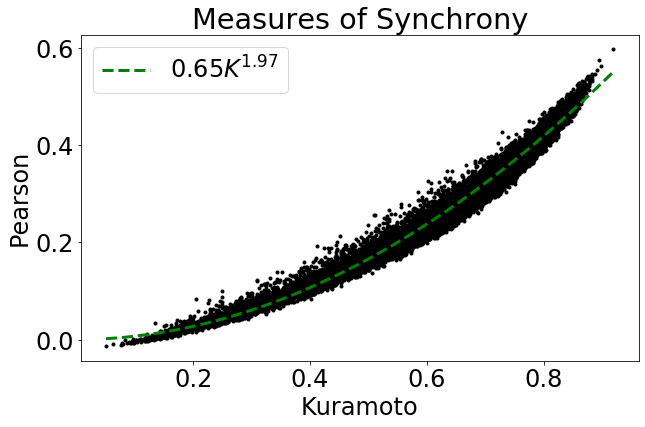

In [9]:
kuramoto_list = [result[kuramoto_index] for result in results]
pearson_list = [result[pearson_index] for result in results]

def model(x, a, b):
    return a*x**b

a, b = curve_fit(model, kuramoto_list, pearson_list)[0]

xs = np.linspace(min(kuramoto_list), max(kuramoto_list), 201)

plt.figure(figsize=(10,6))
plt.plot(kuramoto_list, pearson_list, 'k.')
plt.plot(xs, a*xs**b, 'g--', linewidth=3, label=f'${a:.2f}K^{{{b:.2f}}}$')
plt.xlabel('Kuramoto')
plt.ylabel('Pearson')
plt.title('Measures of Synchrony')
plt.legend()
# plt.savefig('images/ring_synchrony_equivalence.eps')
plt.show()

In [23]:
N_index = results_key.index('N')
variance_index = results_key.index('variance')
radius_index = results_key.index('radius')
coupling_coefficient_index = results_key.index('coupling_coefficient')
kuramoto_index = results_key.index('kuramoto')
pearson_index = results_key.index('pearson')
mean_path_index = results_key.index('mean_path_length')
diameter_index = results_key.index('diameter')
clustering_coefficient_index = results_key.index('clustering_coefficient')
def result_filter(result):
    condition = result[N_index] == 50 and \
                result[radius_index] == 3 and \
                result[coupling_coefficient_index] == .5
    return condition

kuramoto_list = [result[kuramoto_index] for result in results if result_filter(result)]
pearson_list = [result[pearson_index] for result in results if result_filter(result)]
mean_path_list = [result[mean_path_index] for result in results if result_filter(result)]
clustering_coefficient_list = [result[clustering_coefficient_index] for result in results if result_filter(result)]
diameter_list = [result[diameter_index] for result in results if result_filter(result)]

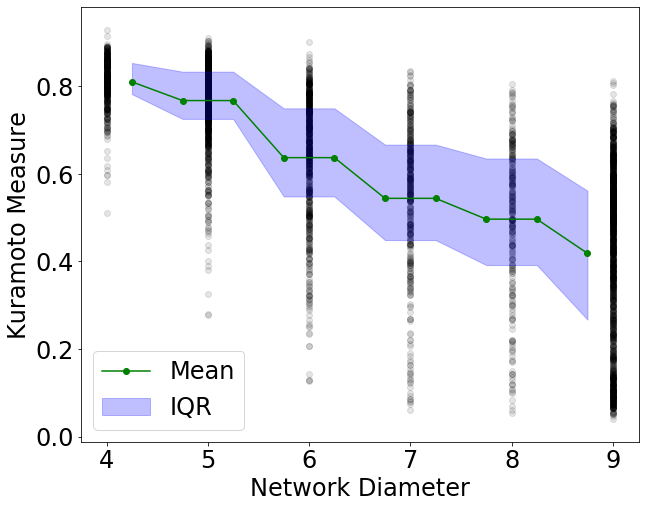

In [24]:
bin_centers, means, Q1s, Q3s = bins_and_averages(diameter_list, kuramoto_list, n=10)

plt.figure(figsize=(10, 8))
plt.scatter(diameter_list, kuramoto_list, color='k', alpha=.1)
plt.plot(bin_centers, means, 'go-', label='Mean')
plt.fill_between(bin_centers, Q1s, Q3s, alpha=.25, label='IQR', color='b')
plt.xlabel('Network Diameter')
plt.ylabel('Kuramoto Measure')
plt.legend()
plt.show()

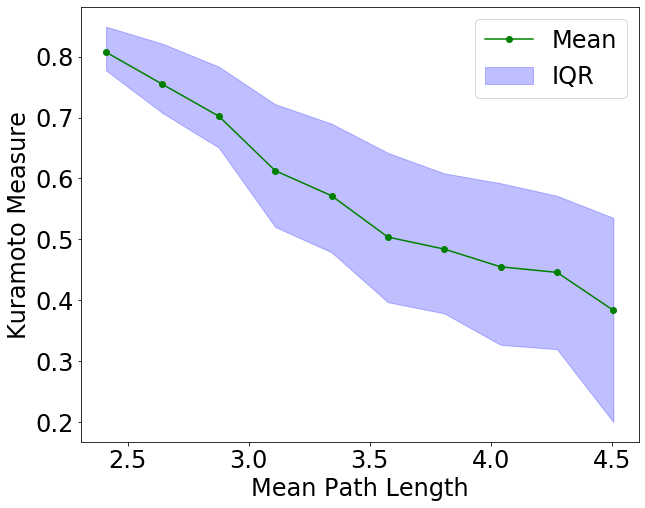

In [20]:
bin_centers, means, Q1s, Q3s = bins_and_averages(mean_path_list, kuramoto_list, n=10)

plt.plot()
plt.figure(figsize=(10, 8))
plt.plot(bin_centers, means, 'go-', label='Mean')
plt.fill_between(bin_centers, Q1s, Q3s, alpha=.25, label='IQR', color='b')
plt.xlabel('Mean Path Length')
plt.ylabel('Kuramoto Measure')
plt.legend()
plt.show()

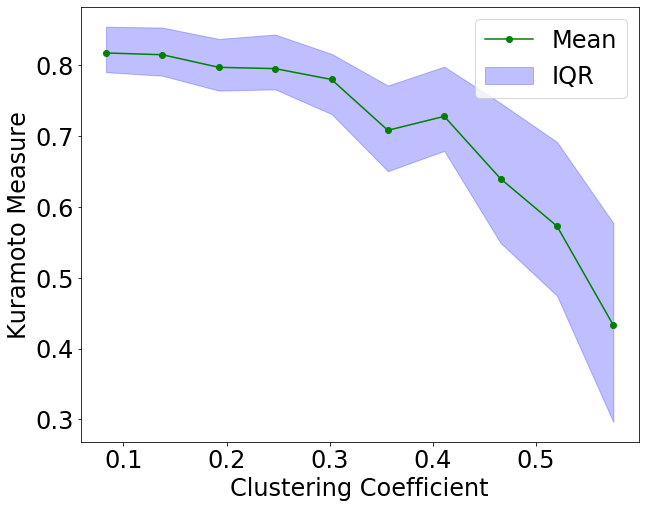

In [21]:
bin_centers, means, Q1s, Q3s = bins_and_averages(clustering_coefficient_list, kuramoto_list, n=10)

plt.figure(figsize=(10, 8))
plt.plot(bin_centers, means, 'go-', label='Mean')
plt.fill_between(bin_centers, Q1s, Q3s, alpha=.25, label='IQR', color='b')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Kuramoto Measure')
plt.legend()
plt.show()

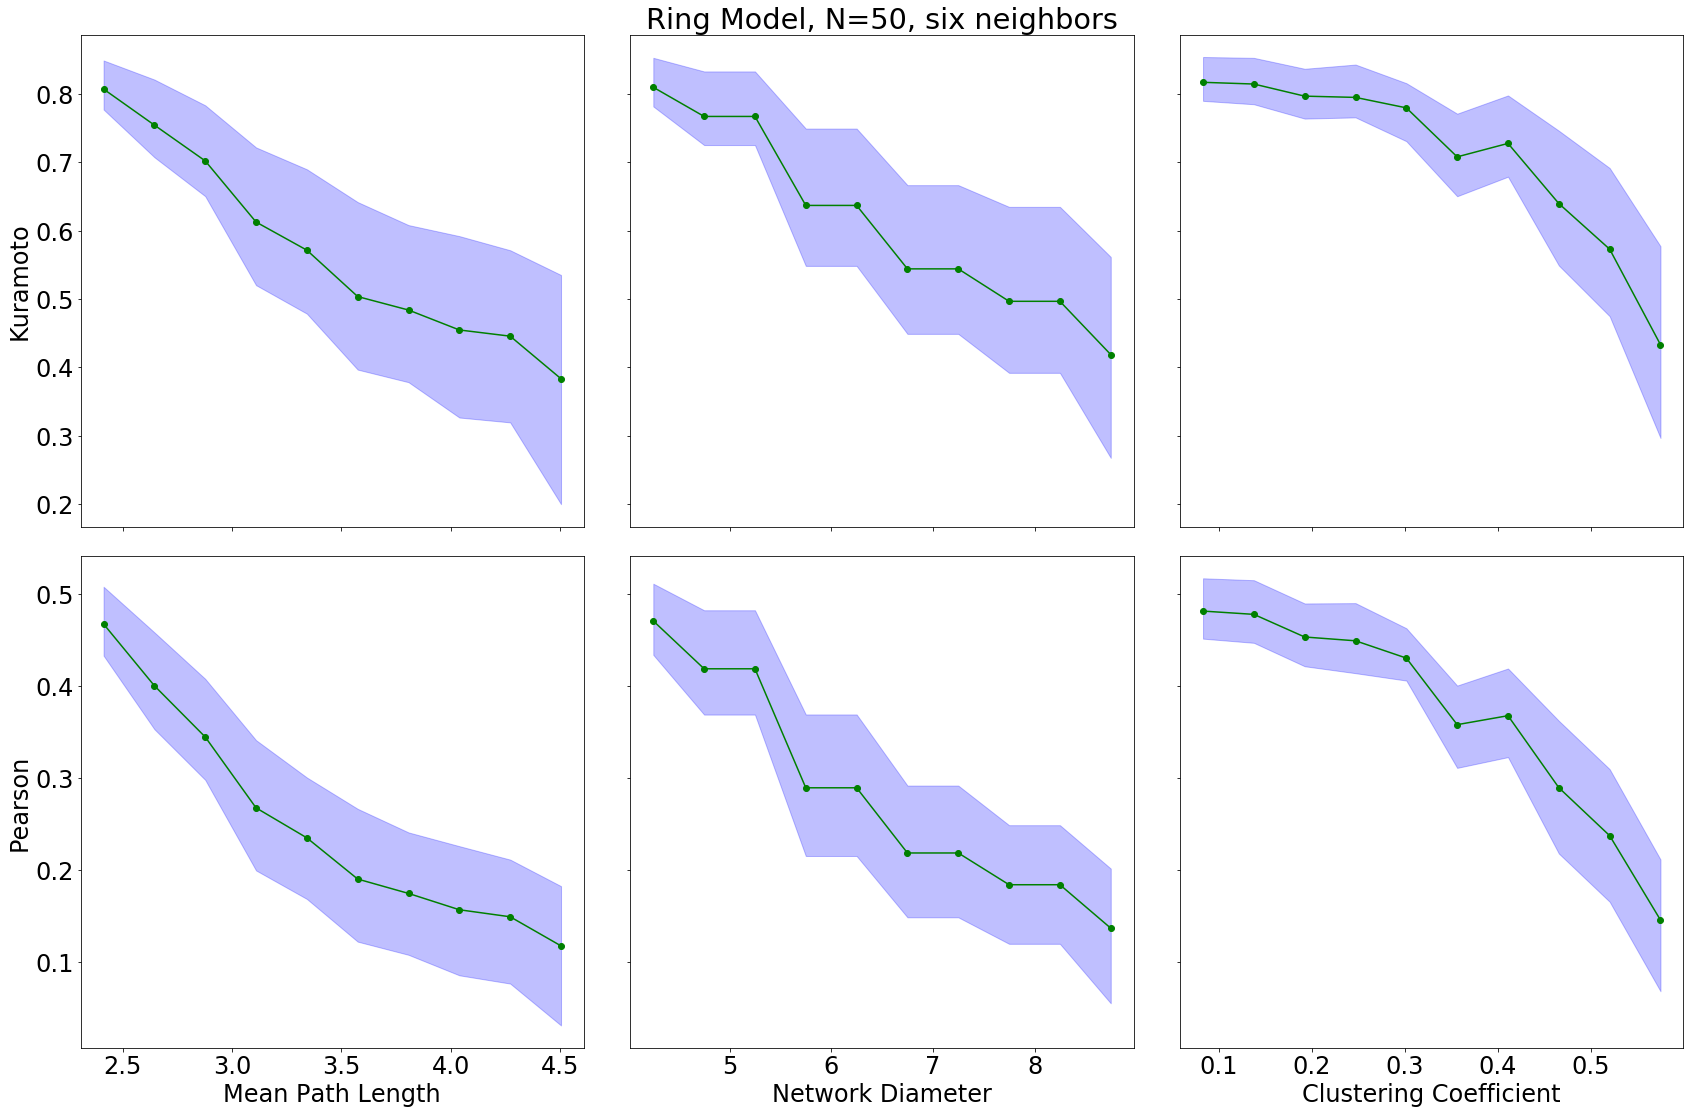

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16), sharey='row', sharex='col')
plt.subplots_adjust(hspace=0.03, wspace=0.03)
for row, y_var in enumerate([kuramoto_list, pearson_list]):
    for col, x_var in enumerate([mean_path_list, diameter_list, clustering_coefficient_list]):
        bin_centers, means, Q1s, Q3s = bins_and_averages(x_var, y_var, n=10)
        axes[row][col].plot(bin_centers, means, 'go-', label='Mean')
        axes[row][col].fill_between(bin_centers, Q1s, Q3s, alpha=.25, label='IQR', color='b')
        
for col, label in enumerate(['Mean Path Length', 'Network Diameter', 'Clustering Coefficient']):
    axes[-1][col].set_xlabel(label)
    
for row, label in enumerate(['Kuramoto', 'Pearson']):
    axes[row][0].set_ylabel(label)
    
axes[0][1].set_title('Ring Model, N=50, six neighbors')

plt.tight_layout()

# plt.savefig('images/summary_stats_ring.png')
        
plt.show()

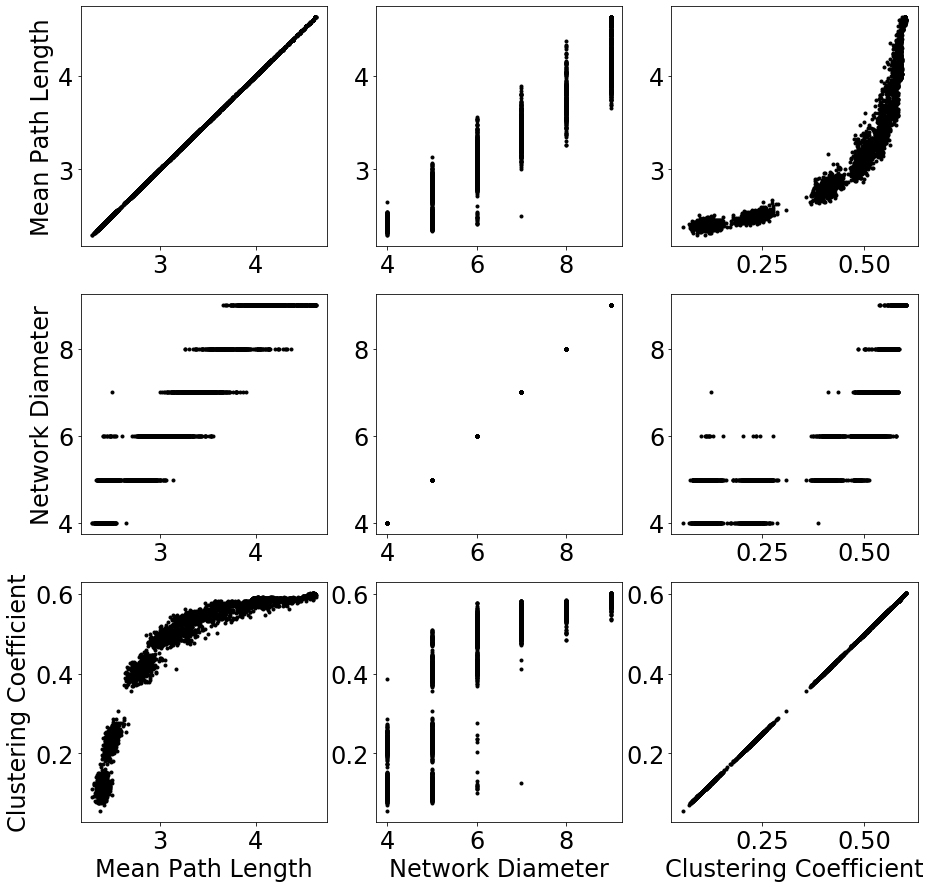

In [158]:
data_and_labels = [
    (mean_path_list, 'Mean Path Length'),
    (diameter_list, 'Network Diameter'),
    (clustering_coefficient_list, 'Clustering Coefficient')
]

fig, axes = plt.subplots(len(data_and_labels), len(data_and_labels), figsize=(15,15))

for col, x_pair in enumerate(data_and_labels):
    x_data, x_label = x_pair
    axes[-1][col].set_xlabel(x_label)
for row, y_pair in enumerate(data_and_labels):
    y_data, y_label = y_pair
    axes[row][0].set_ylabel(y_label)

for col, x_pair in enumerate(data_and_labels):
    x_data, x_label = x_pair
    for row, y_pair in enumerate(data_and_labels):
        y_data, y_label = y_pair
        axes[row][col].plot(x_data, y_data, 'k.')

In [105]:
random_edges_list

[0, 1, 2, 5, 10, 20, 50, 'max']

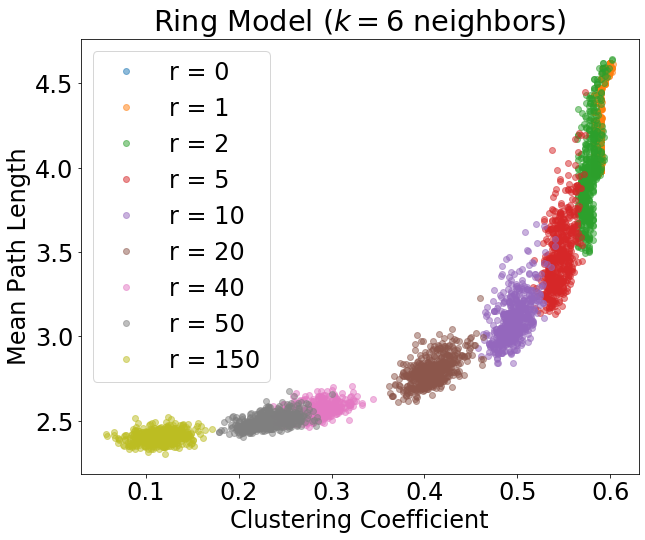

In [39]:
num_edges_index = results_key.index('random_edges')

plt.figure(figsize=(10, 8))
for num_edges in random_edges_list:
    if num_edges == 'max':
        num_edges = 150
    def test_filter(result, num_edges):
        condition = result[radius_index] == 3 and \
                result[num_edges_index] == num_edges
        return condition
    filtered_clustering_coeff = [result[clustering_coefficient_index] for result in results if test_filter(result, num_edges)]
    filtered_mean_path_legth = [result[mean_path_index] for result in results if test_filter(result, num_edges)]
    plt.plot(filtered_clustering_coeff, filtered_mean_path_legth, 'o', alpha=.5, label=f'r = {num_edges}')
plt.legend()

plt.xlabel('Clustering Coefficient')
plt.ylabel('Mean Path Length')
plt.legend()

plt.title('Ring Model ($k=6$ neighbors)')

# plt.savefig('images/ring_6_clustering_mean_path.png')

plt.show()

# Presentation Plots

In [239]:
N_index = results_key.index('N')
variance_index = results_key.index('variance')
radius_index = results_key.index('radius')
coupling_coefficient_index = results_key.index('coupling_coefficient')
kuramoto_index = results_key.index('kuramoto')
pearson_index = results_key.index('pearson')
mean_path_index = results_key.index('mean_path_length')
diameter_index = results_key.index('diameter')
clustering_coefficient_index = results_key.index('clustering_coefficient')
def result_filter(result):
    condition = result[N_index] == 50 and \
                result[radius_index] == 3 and \
                result[coupling_coefficient_index] == 0.3
    return condition

kuramoto_list = [result[kuramoto_index] for result in results if result_filter(result)]
pearson_list = [result[pearson_index] for result in results if result_filter(result)]
mean_path_list = [result[mean_path_index] for result in results if result_filter(result)]
clustering_coefficient_list = [result[clustering_coefficient_index] for result in results if result_filter(result)]
diameter_list = [result[diameter_index] for result in results if result_filter(result)]

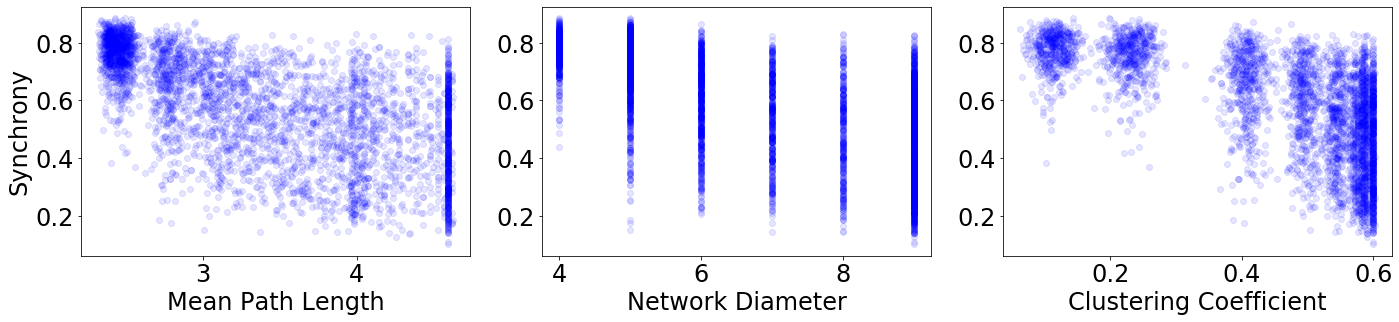

In [241]:
data_and_labels = [
    (mean_path_list, 'Mean Path Length'),
    (diameter_list, 'Network Diameter'),
    (clustering_coefficient_list, 'Clustering Coefficient')
]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for col, (data, label) in enumerate(data_and_labels):
    axes[col].plot(data, kuramoto_list, 'bo', alpha = 0.1)
    axes[col].set_xlabel(label)
axes[0].set_ylabel('Synchrony')

plt.tight_layout()

# plt.savefig('images/presentation_raw_data.png')

plt.show()

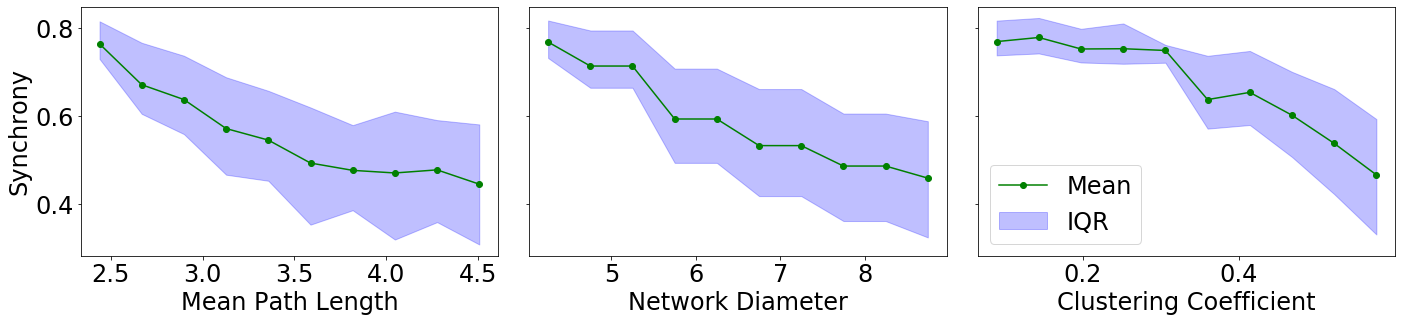

In [243]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey='row', sharex='col')
plt.subplots_adjust(hspace=0.03, wspace=0.03)

for col, x_var in enumerate([mean_path_list, diameter_list, clustering_coefficient_list]):
    bin_centers, means, Q1s, Q3s = bins_and_averages(x_var, kuramoto_list, n=10)
    axes[col].plot(bin_centers, means, 'go-', label='Mean')
    axes[col].fill_between(bin_centers, Q1s, Q3s, alpha=.25, label='IQR', color='b')
        
for col, label in enumerate(['Mean Path Length', 'Network Diameter', 'Clustering Coefficient']):
    axes[col].set_xlabel(label)
    
axes[0].set_ylabel('Synchrony')
axes[-1].legend()
plt.tight_layout()

# plt.savefig('images/presentation_summary_stats.png')
        
plt.show()

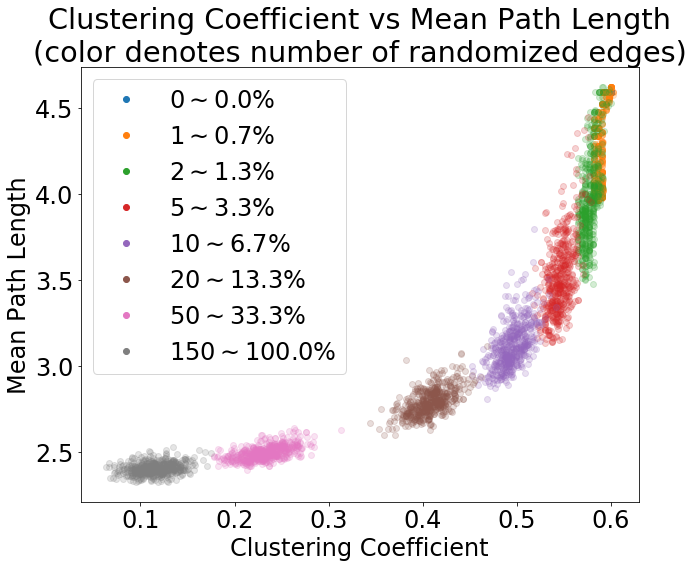

In [249]:
num_edges_index = results_key.index('random_edges')

plt.figure(figsize=(10, 8))
for num_edges in random_edges_list:
    if num_edges == 'max':
        num_edges = 150
    def test_filter(result, num_edges):
        condition = result[N_index] == 50 and \
                result[radius_index] == 3 and \
                result[coupling_coefficient_index] == 0.3 and \
                result[num_edges_index] == num_edges
        return condition
    filtered_clustering_coeff = [result[clustering_coefficient_index] for result in results if test_filter(result, num_edges)]
    filtered_mean_path_legth = [result[mean_path_index] for result in results if test_filter(result, num_edges)]
    my_plot = plt.plot(filtered_clustering_coeff, filtered_mean_path_legth, 'o', alpha=.2)
    plt.plot([], [], 'o', color=my_plot[0].get_color(), label=f'${num_edges}\\sim{num_edges/150*100:.1f}\\%$')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Mean Path Length')
plt.title('Clustering Coefficient vs Mean Path Length\n(color denotes number of randomized edges)')
plt.legend()

# plt.savefig('images/presentation_mean_path_length_vs_clustering_coefficient.png')

plt.show()

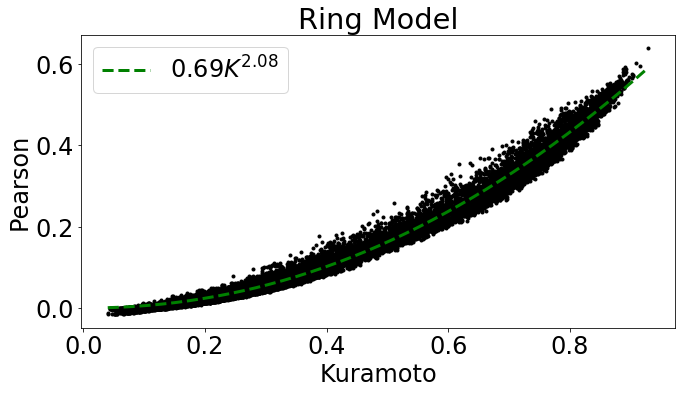

In [98]:
kuramoto_list = [result[kuramoto_index] for result in results]
pearson_list = [result[pearson_index] for result in results]

def model(x, a, b):
    return a*x**b

a, b = curve_fit(model, kuramoto_list, pearson_list)[0]

xs = np.linspace(min(kuramoto_list), max(kuramoto_list), 201)

plt.figure(figsize=(10,6))
plt.plot(kuramoto_list, pearson_list, 'k.')
plt.plot(xs, a*xs**b, 'g--', linewidth=3, label=f'${a:.2f}K^{{{b:.2f}}}$')
plt.xlabel('Kuramoto')
plt.ylabel('Pearson')
plt.title('Ring Model')
plt.legend()

plt.tight_layout()

plt.savefig('images/kuramoto_vs_pearson.png')

plt.show()

# Summary stats and raw data

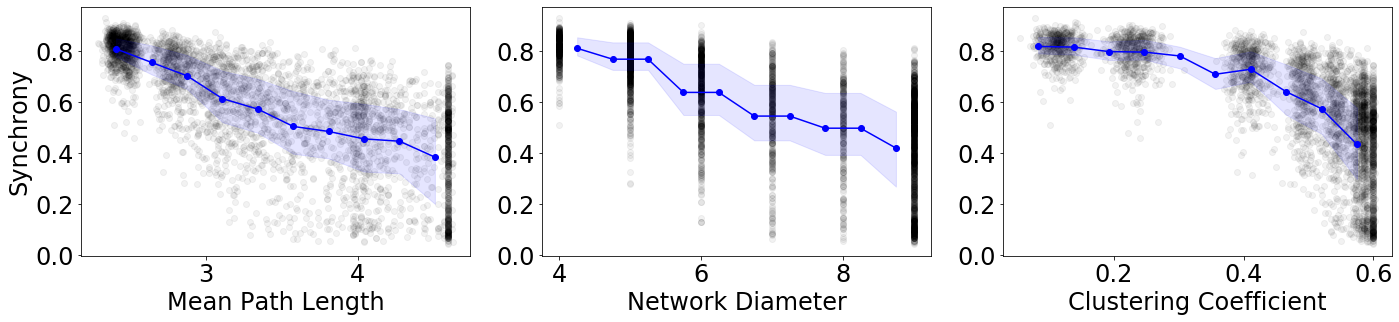

In [43]:
data_and_labels = [
    (mean_path_list, 'Mean Path Length'),
    (diameter_list, 'Network Diameter'),
    (clustering_coefficient_list, 'Clustering Coefficient')
]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for col, (data, label) in enumerate(data_and_labels):
    bin_centers, means, Q1s, Q3s = bins_and_averages(data, kuramoto_list, n=10)
    axes[col].plot(data, kuramoto_list, 'ko', alpha = 0.05, zorder=0)
    axes[col].plot(bin_centers, means, 'bo-', label='Mean', zorder=2)
    axes[col].fill_between(bin_centers, Q1s, Q3s, alpha=.1, label='IQR', color='b', zorder=1)
    axes[col].set_xlabel(label)
axes[0].set_ylabel('Synchrony')

plt.tight_layout()

# plt.savefig('images/presentation_raw_data.png')

plt.show()

In [10]:
def summary_stats(xs, ys, n=20, bin_centers=None):
    xs = np.array(xs)
    ys = np.array(ys)
    if bin_centers is None:
        lower, upper = np.min(xs), np.max(xs)
        bin_boundaries = np.linspace(lower, upper, n+1)
        bin_centers = (bin_boundaries[1:] + bin_boundaries[:-1])/2
    else:
        bin_centers = np.array(bin_centers)
        bin_boundaries = np.zeros(len(bin_centers)+1)
        bin_boundaries[0] = bin_centers[0]-1
        bin_boundaries[-1] = bin_centers[-1]+1
        bin_boundaries[1:-1] = (bin_centers[1:] + bin_centers[:-1])/2
    means = []
    Q1s = []
    Q3s = []
    for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
        mask = np.logical_and(xs >= lower, xs <=upper)
        data = ys[mask]
        means.append(np.mean(data))
        Q1s.append(np.quantile(data, .25))
        Q3s.append(np.quantile(data, .75))
    return bin_centers, means, Q1s, Q3s

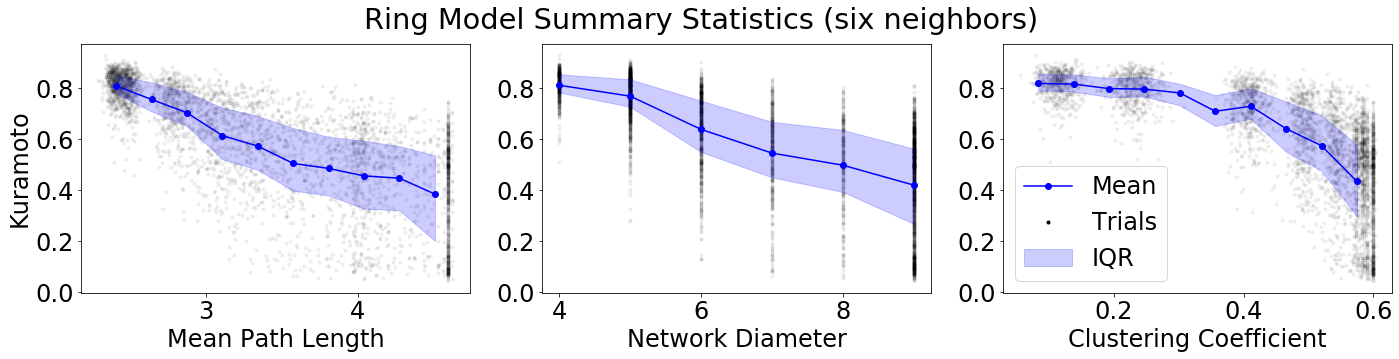

In [97]:
data_and_labels = [
    (mean_path_list, 'Mean Path Length'),
    (diameter_list, 'Network Diameter'),
    (clustering_coefficient_list, 'Clustering Coefficient')
]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for col, (data, label) in enumerate(data_and_labels):
    if label == 'Network Diameter':
        bin_centers, means, Q1s, Q3s = summary_stats(data, kuramoto_list, bin_centers = list(set(data)))
    else:
        bin_centers, means, Q1s, Q3s = bins_and_averages(data, kuramoto_list, n=10)
    axes[col].plot(data, kuramoto_list, 'k.', alpha = 0.05, zorder=0)
    axes[col].plot(bin_centers, means, 'bo-', label='Mean', zorder=2)
    axes[col].fill_between(bin_centers, Q1s, Q3s, alpha=.2, label='IQR', color='b', zorder=1)
    axes[col].set_xlabel(label)
axes[0].set_ylabel('Kuramoto')

axes[-1].plot([], [], 'k.', label='Trials')
axes[-1].legend()

plt.suptitle('Ring Model Summary Statistics (six neighbors)', y=1.03)


plt.tight_layout()

# plt.savefig('images/summary_stats_ring.png', bbox_inches='tight')

plt.show()

In [53]:
list(set(diameter_list))

[4, 5, 6, 7, 8, 9]

# Figures

In [29]:
def summary_stats(xs, ys, n=20, bin_centers=None):
    xs = np.array(xs)
    ys = np.array(ys)
    #bin_centers = scipy.cluster.vq.kmeans(np.array([clustering_coefficient_list, kuramoto_list]).T, len(random_edges_list))[0][:,0]
    if bin_centers is None:
        lower, upper = np.min(xs), np.max(xs)
        bin_boundaries = np.linspace(lower, upper, n+1)
        bin_centers = (bin_boundaries[1:] + bin_boundaries[:-1])/2
    else:
        bin_centers = np.array(bin_centers)
        bin_boundaries = np.zeros(len(bin_centers)+1)
        bin_boundaries[0] = bin_centers[0]-1
        bin_boundaries[-1] = bin_centers[-1]+1
        bin_boundaries[1:-1] = (bin_centers[1:] + bin_centers[:-1])/2
    means = []
    Q1s = []
    Q3s = []
    for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
        mask = np.logical_and(xs >= lower, xs <=upper)
        data = ys[mask]
        means.append(np.mean(data))
        Q1s.append(np.quantile(data, .25))
        Q3s.append(np.quantile(data, .75))
    return bin_centers, means, Q1s, Q3s

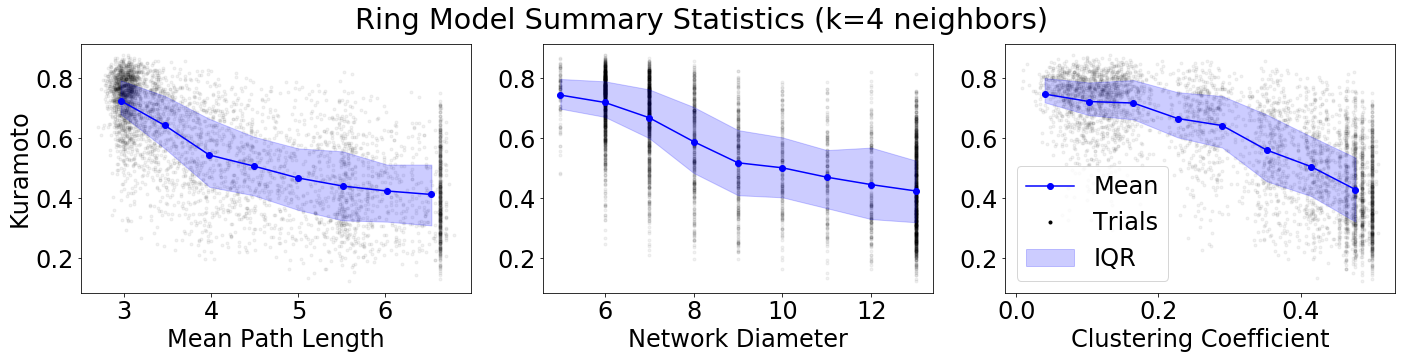

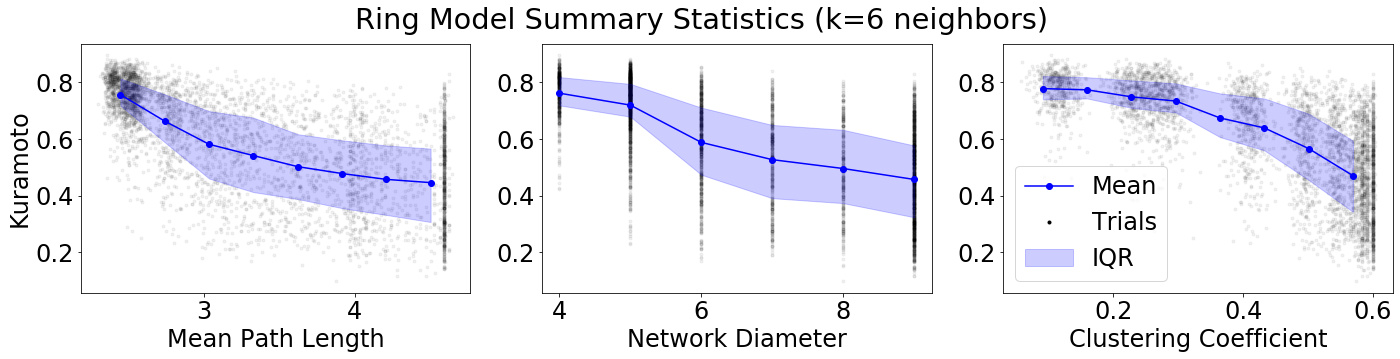

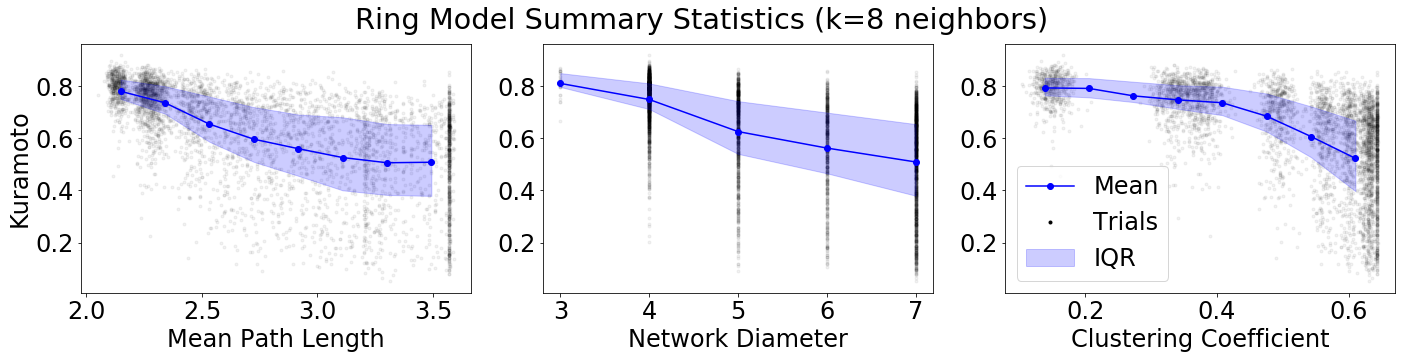

In [37]:
N_index = results_key.index('N')
radius_index = results_key.index('radius')
coupling_coefficient_index = results_key.index('coupling_coefficient')
kuramoto_index = results_key.index('kuramoto')
pearson_index = results_key.index('pearson')
mean_path_index = results_key.index('mean_path_length')
diameter_index = results_key.index('diameter')
clustering_coefficient_index = results_key.index('clustering_coefficient')

for radius in [2, 3, 4]:

    def result_filter(result):
        condition = result[radius_index] == radius
        return condition

    kuramoto_list = [result[kuramoto_index] for result in results if result_filter(result)]
    pearson_list = [result[pearson_index] for result in results if result_filter(result)]
    mean_path_list = [result[mean_path_index] for result in results if result_filter(result)]
    clustering_coefficient_list = [result[clustering_coefficient_index] for result in results if result_filter(result)]
    diameter_list = [result[diameter_index] for result in results if result_filter(result)]
    
    data_and_labels = [
        (mean_path_list, 'Mean Path Length'),
        (diameter_list, 'Network Diameter'),
        (clustering_coefficient_list, 'Clustering Coefficient')
    ]

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    for col, (data, label) in enumerate(data_and_labels):
        if label == 'Network Diameter':
            bin_centers, means, Q1s, Q3s = summary_stats(data, kuramoto_list, bin_centers = list(set(data)))
        else:
            bin_centers, means, Q1s, Q3s = bins_and_averages(data, kuramoto_list, n=8)
        axes[col].plot(data, kuramoto_list, 'k.', alpha = 0.05, zorder=0)
        axes[col].plot(bin_centers, means, 'bo-', label='Mean', zorder=2)
        axes[col].fill_between(bin_centers, Q1s, Q3s, alpha=.2, label='IQR', color='b', zorder=1)
        axes[col].set_xlabel(label)
    axes[0].set_ylabel('Kuramoto')

    axes[-1].plot([], [], 'k.', label='Trials')
    axes[-1].legend()

    plt.suptitle(f'Ring Model Summary Statistics (k={2*radius} neighbors)', y=1.03)


    plt.tight_layout()

#     plt.savefig(f'images/summary_stats_ring_{2*radius}.png', bbox_inches='tight')

    plt.show()